In [1]:
# Attempting to build a network that would work
# for all the cases of the damped harmonic oscillator.

# We will reuse the same model structure as from before, which
# contains a blend of sin and tanh activations.

# But we will also instead create a dataset that
# contains a varied set of damping coefficients
# so that the model can learn to generalize for all cases.

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [5]:
# Right hand side of the system 
def damped_rhs(t, y, gamma, w):
    u, v = y
    du_dt = v
    dv_dt = -2 * gamma * v - w**2 * u
    return [du_dt, dv_dt]

In [6]:
# Parameter ranges for each of the damping cases
def sample_underdamped(n):
    w = np.random.uniform(0.8, 2.0, size=(n, 1))
    gamma_frac = np.random.uniform(0.05, 0.7, size=(n, 1))
    gamma = gamma_frac * w              # gamma < w
    return w, gamma

def sample_overdamped(n):
    w = np.random.uniform(0.5, 1.5, size=(n, 1))
    factor = np.random.uniform(1.3, 2.5, size=(n, 1))
    gamma = factor * w                  # gamma > w
    return w, gamma

def sample_critical(n):
    w = np.random.uniform(0.8, 2.0, size=(n, 1))
    
    # small jitter around equality so ODE is well-behaved numerically
    jitter = np.random.uniform(0.98, 1.02, size=(n, 1))
    gamma = w * jitter                  # gamma ≈ w
    return w, gamma

In [7]:
# Generate dataset covering all regimes
def make_data_all(
    n_per_regime=200,   # systems per regime
    num_points=200,
    t_max=4 * np.pi
):

    def generate_for_regime(w_all, gamma_all):
        n_systems = w_all.shape[0]
        u0_all = np.random.uniform(-1.5, 1.5, size=(n_systems, 1))
        v0_all = np.random.uniform(-1.0, 1.0, size=(n_systems, 1))

        t_grid = np.linspace(0.0, t_max, num_points).reshape(-1, 1)

        X_list, y_list = [], []

        for u0, v0, w, gamma in zip(u0_all, v0_all, w_all, gamma_all):
            sol = solve_ivp(
                fun=lambda tau, y: damped_rhs(tau, y, float(gamma), float(w)),
                t_span=(0.0, float(t_grid[-1, 0])),
                y0=[float(u0), float(v0)],
                t_eval=t_grid.flatten(),
                method="RK45",
                rtol=1e-8,
                atol=1e-8,
            )
            u_traj = sol.y[0].reshape(-1, 1)

            U0 = np.full_like(t_grid, u0)
            V0 = np.full_like(t_grid, v0)
            W  = np.full_like(t_grid, w)
            G  = np.full_like(t_grid, gamma)

            # discriminant feature: gamma^2 - w^2
            D  = np.full_like(t_grid, gamma**2 - w**2)

            X_traj = np.hstack([U0, V0, W, G, D, t_grid])
            y_traj = u_traj

            X_list.append(X_traj)
            y_list.append(y_traj)

        X_reg = np.vstack(X_list).astype(np.float32)
        y_reg = np.vstack(y_list).astype(np.float32)
        return X_reg, y_reg

    # Generate for each regime
    w_under, gamma_under = sample_underdamped(n_per_regime)
    w_over,  gamma_over  = sample_overdamped(n_per_regime)
    w_crit,  gamma_crit  = sample_critical(n_per_regime)

    X_under, y_under = generate_for_regime(w_under, gamma_under)
    X_over,  y_over  = generate_for_regime(w_over,  gamma_over)
    X_crit,  y_crit  = generate_for_regime(w_crit,  gamma_crit)

    # Stack all regimes
    X = np.vstack([X_under, X_over, X_crit])
    y = np.vstack([y_under, y_over, y_crit])

    # Scale t (last column) to [0,1]
    X[:, -1] /= t_max

    return X, y, t_max

In [8]:
# Creating the sin activation model
def sin_activation(x):
    return tf.sin(x)

In [9]:
# Calling the data generation
X, y, T_MAX = make_data_all(n_per_regime=250, num_points=200)
print("Combined dataset shape:", X.shape, y.shape)

# Shuffling the dataset
idx = np.random.permutation(len(X))
X, y = X[idx], y[idx]

split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_val,   y_val   = X[split:], y[split:]

/var/folders/db/nfyhgnf50fxd8qjfrpdb671c0000gn/T/ipykernel_78369/2559218638.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y0=[float(u0), float(v0)],
/var/folders/db/nfyhgnf50fxd8qjfrpdb671c0000gn/T/ipykernel_78369/2559218638.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fun=lambda tau, y: damped_rhs(tau, y, float(gamma), float(w)),


Combined dataset shape: (150000, 6) (150000, 1)


In [11]:
# Building the neural network model
model = models.Sequential([
    layers.Input(shape=(6,)),               # [u0, v0, w, gamma, disc, t_scaled]
    layers.Dense(256, activation="tanh"),
    layers.Dense(256, activation=sin_activation),
    layers.Dense(256, activation="tanh"),
    layers.Dense(128, activation="tanh"),
    layers.Dense(1)
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 256)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 166,401 (650.00 KB)

 Trainable params: 166,401 (650.00 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss="mse"
)

In [13]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=512,
    verbose=2
)

Epoch 1/100
235/235 - 4s - 16ms/step - loss: 0.0627 - val_loss: 0.0203
Epoch 2/100
235/235 - 3s - 11ms/step - loss: 0.0156 - val_loss: 0.0114
Epoch 3/100
235/235 - 2s - 10ms/step - loss: 0.0101 - val_loss: 0.0082
Epoch 4/100
235/235 - 2s - 9ms/step - loss: 0.0075 - val_loss: 0.0066
Epoch 5/100
235/235 - 2s - 10ms/step - loss: 0.0063 - val_loss: 0.0071
Epoch 6/100
235/235 - 3s - 11ms/step - loss: 0.0055 - val_loss: 0.0073
Epoch 7/100
235/235 - 2s - 10ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 8/100
235/235 - 3s - 11ms/step - loss: 0.0047 - val_loss: 0.0040
Epoch 9/100
235/235 - 3s - 11ms/step - loss: 0.0042 - val_loss: 0.0037
Epoch 10/100
235/235 - 3s - 12ms/step - loss: 0.0039 - val_loss: 0.0035
Epoch 11/100
235/235 - 3s - 12ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 12/100
235/235 - 3s - 14ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 13/100
235/235 - 3s - 13ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 14/100
235/235 - 4s - 15ms/step - loss: 0.0028 - val_loss: 0.0030
Ep

In [14]:
# Test function to evaluate the model on each case
def test_system(u0_test, v0_test, w_test, gamma_test, title):
    t_grid = np.linspace(0.0, 4 * np.pi, 300).reshape(-1, 1).astype(np.float32)

    # true solution
    sol = solve_ivp(
        fun=lambda tau, y: damped_rhs(tau, y, gamma_test, w_test),
        t_span=(0.0, float(t_grid[-1, 0])),
        y0=[u0_test, v0_test],
        t_eval=t_grid.flatten(),
        method="RK45",
        rtol=1e-8,
        atol=1e-8,
    )
    u_true = sol.y[0].reshape(-1, 1).astype(np.float32)

    # NN input
    t_scaled = t_grid / T_MAX
    disc = gamma_test**2 - w_test**2
    D = np.full_like(t_scaled, disc)

    X_test = np.hstack([
        np.full_like(t_scaled, u0_test),
        np.full_like(t_scaled, v0_test),
        np.full_like(t_scaled, w_test),
        np.full_like(t_scaled, gamma_test),
        D,
        t_scaled
    ]).astype(np.float32)

    u_pred = model.predict(X_test)

    # plot
    plt.figure(figsize=(8, 4))
    plt.plot(t_grid, u_true, "k-", label="True (SciPy)")
    plt.plot(t_grid, u_pred, "r--", label="NN")
    plt.xlabel("t")
    plt.ylabel("u(t)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


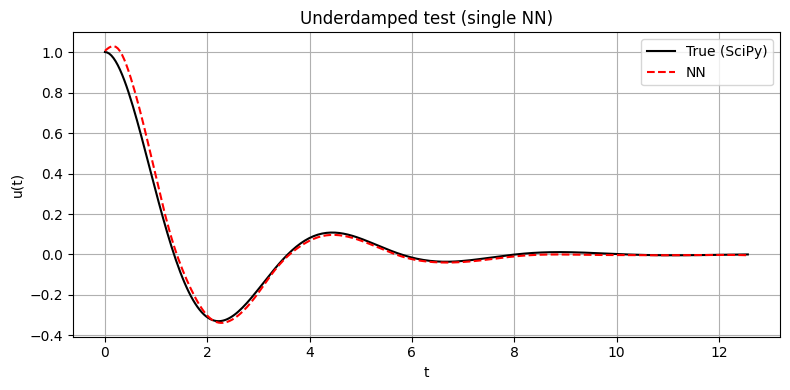

In [15]:
# Underdamped case: gamma < w
test_system(
    u0_test=1.0, v0_test=0.0,
    w_test=1.5, gamma_test=0.5,
    title="Underdamped test (single NN)"
)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


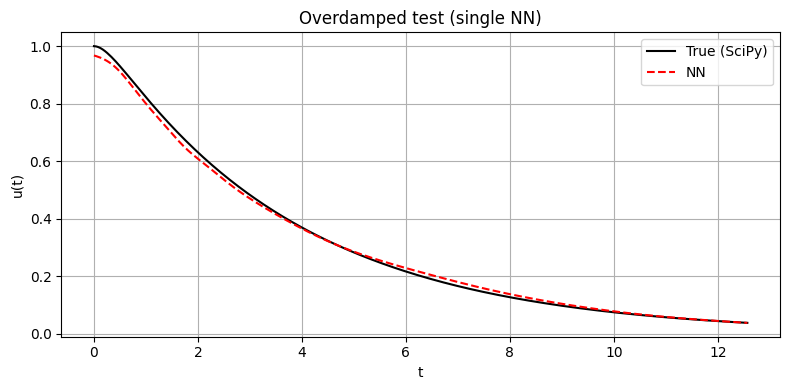

In [16]:
# Overdamped case: gamma > w
test_system(
    u0_test=1.0, v0_test=0.0,
    w_test=1.0, gamma_test=2.0,
    title="Overdamped test (single NN)"
)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


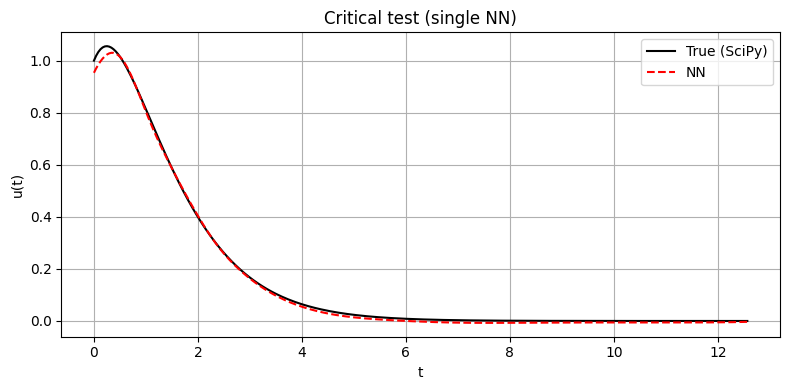

In [17]:
# Critically damped case: gamma ≈ w
test_system(
    u0_test=1.0, v0_test=0.5,
    w_test=1.2, gamma_test=1.2,
    title="Critical test (single NN)"
)

In [ ]:
# So we found that our model worked well for all three cases
# using a single neural network trained on a combined dataset.

# Takeaway: Need to construct datasets that cover all the cases and 
# provide discriminative features, like sin activation, to the model.